# Tâche 9

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import integrate
import matplotlib.pyplot as plt

In [2]:
mp_key = "bsvkvKtIeOMa1amMu5ZlNLCEpRMHPSeb"
mp_id = "mp-505297"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

### Données

In [4]:
temps = np.arange(0,1000,5)
R = 8.314
Nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temps[i]) for i in range(len(temps))])/(3*Nat*R)

## Courbes de la chaleur spécifique

### Courbe selon nos données

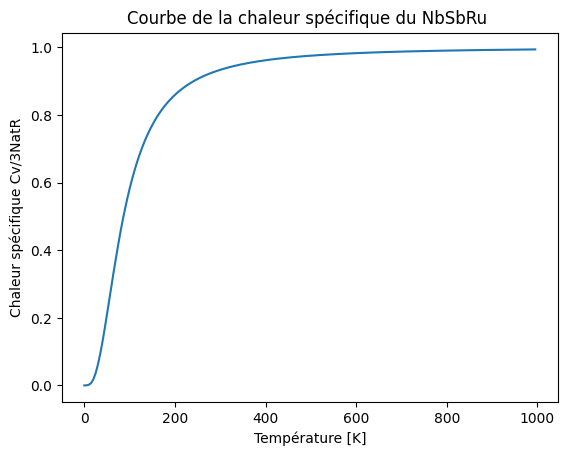

In [5]:
plt.plot(temps, ph_cv)
plt.title('Courbe de la chaleur spécifique du NbSbRu ')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.show()

### Courbe selon le modèle de  Debye

L'équation de la chaleur spécifique molaire selon le modèle de Debye:
\begin{equation}
    C_{\text{Debye}}/3 N_\text{at} R = 3 \left( \frac{T}{\theta_D} \right)^3 \int_{0}^{\frac{\theta_D}{T}} \frac{x^4 e^x}{(e^x - 1)^2} \, dx
\end{equation}
Debye se base sur l'hypothèse que toutes les fréquences de vibrations suivent la même dispersion linéaire $\omega_D(q) = vq$ avec $v$ la vitesse de phase et $q$ le vecteur d'onde.

Température de Debye qui minimise l'erreur au sens des moindres carrés sur l'ensemble de la courbe = 348 K


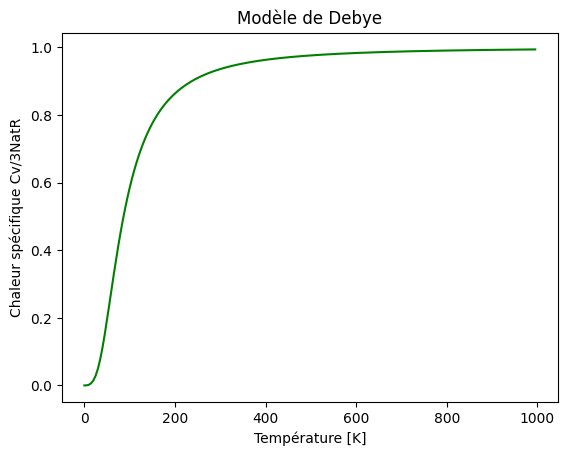

In [11]:
def f(x):
    return (x**4)*np.exp(x) / ((np.exp(x)-1)**2)

def debye(d, T):
    cv_pred = 3*((T/d)**3)*integrate.quad(f, 0, d/T)[0]
    return cv_pred

er_min_d = 0
t_d = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv_pred = debye(i, temps[j])
        a = (cv_pred-ph_cv[j])**2
        erreur += a
    if i==1:
        er_min_d = erreur
    if erreur < er_min_d:
        er_min_d = erreur
        t_d = i
print("Température de Debye qui minimise l'erreur au sens des moindres carrés sur l'ensemble de la courbe =",t_d,"K")

cv_debye=[temps[0]]
for i in range(1,200):
    cv_debye.append(debye(t_d, temps[i]))

plt.plot(temps, cv_debye, color="green")
plt.title("Modèle de Debye")
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.show()

### Courbe selon le modèle d'Einstein

L'équation de la chaleur spécifique molaire selon le modèle de Einstein:
\begin{equation}
    C_{\text{Einstein}}/3 N_\text{at} R= \frac{\left( \frac{\theta_E}{T} \right)^2 e^{\frac{\theta_E}{T}}}{(e^{\frac{\theta_E}{T}} - 1)^2}
\end{equation}
Einstein se base sur l'hypothèse que toutes les fréquences de vibrations sont égales à $\omega_E$.

Température d'Einstein qui minimise l'erreur au sens des moindres carrés sur l'ensemble de la courbe = 257 K


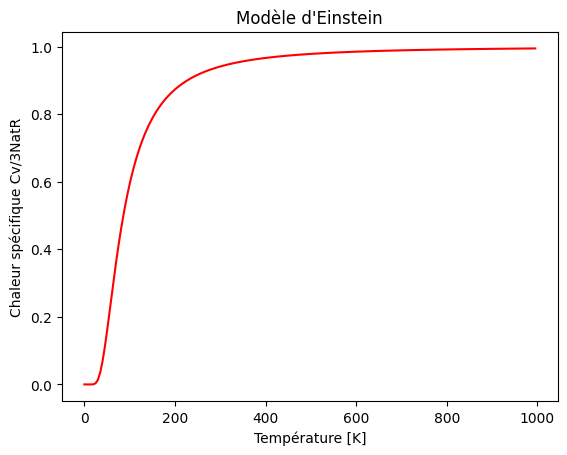

In [12]:
def einstein(e, T):
    cv_pred = ((e/T)**2)*np.exp(e/T) / ((np.exp(e/T)-1)**2)
    return cv_pred

er_min_e = 0
t_e = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv_pred = einstein(i, temps[j])
        a = (cv_pred-ph_cv[j])**2
        erreur += a
    if i==1:
        er_min_e = erreur
    if erreur < er_min_e:
        er_min_e = erreur
        t_e = i
print("Température d'Einstein qui minimise l'erreur au sens des moindres carrés sur l'ensemble de la courbe =",t_e,"K")

cv_einstein =[temps[0]]
for i in range(1,200):
    cv_einstein.append(einstein(t_e, temps[i]))

plt.plot(temps, cv_einstein, color='red')
plt.title("Modèle d'Einstein")
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.show()

### Représentation des 3 courbes de chaleur spécifique

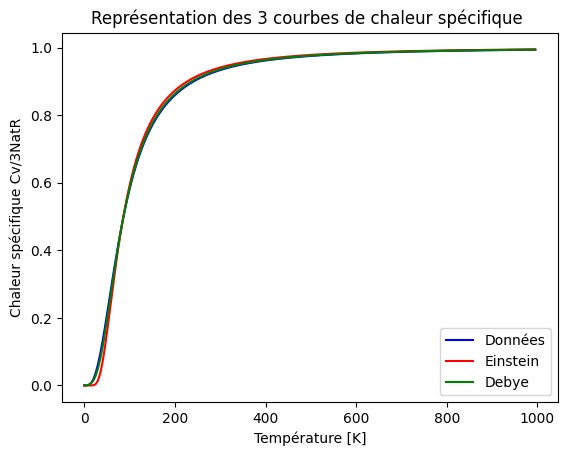

In [8]:
plt.plot(temps, ph_cv, label='Données', color='blue')
plt.plot(temps, cv_einstein, label="Einstein", color='red')
plt.plot(temps, cv_debye, label="Debye", color="green")
plt.title('Représentation des 3 courbes de chaleur spécifique ')
plt.xlabel('Température [K]')
plt.ylabel('Chaleur spécifique Cv/3NatR')
plt.legend()
plt.show()

Les deux modèles prédisent assez bien la chaleur spécifique du matériau mais le modèle d'Einstein prédit moins bien que le modèle de Debye. Au vue des hypothèse des 2 modèles on pouvait s'y attendre,l'hypothèse d'Einstein selon laquelle les fréquences de vibration seraient toutes égales à $\omega_E$ est moins précise que l'hypothèse de la loi de dispersion linéaire des fréquences sur laquelle se base Debye.

## Les trois densités d'états de phonons

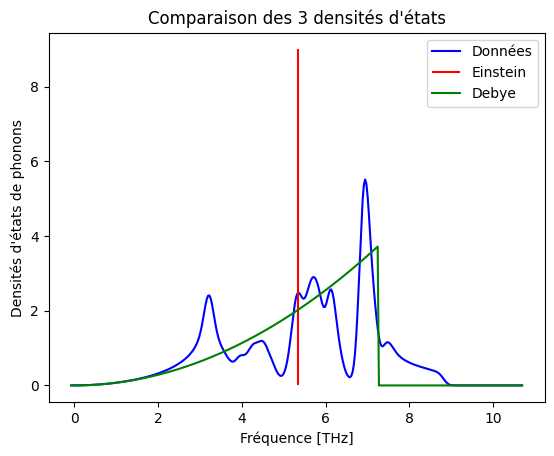

In [10]:
k_B = 1.380649e-23
conv_THz = 1e-12
h_b = 1.055e-34

f = ph_dos.frequencies 
d = ph_dos.densities

omega_e = conv_THz*k_B*t_e/h_b
f_e = omega_e/(2*np.pi)

omega_d = conv_THz*k_B*t_d /h_b

dd = np.zeros(len(f))
for i,fe in enumerate(f):
    omega = 2*np.pi*fe
    if omega < omega_d:
        dd[i] = (9*Nat*(omega)**2/(omega_d**3))

plt.plot(f, d,color="blue", label="Données")
plt.vlines(f_e, 0, 3 * Nat ,color="red", label = "Einstein")
plt.plot(f, dd*(2*np.pi), color='green', label="Debye")
plt.title("Comparaison des 3 densités d'états")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence [THz]")
plt.legend()
plt.show()

La densité d'état de phonon représente les différents modes de vibrations accessibles pour une fréquence donnée pour les phonons. La densité d'état totale pour un matériau (l'aire sous la courbe) vaut $3 N_\text{at}$. En effet, chaque atome peut vibrer selon 3 directions. Les modèles d'Einstein et de Debye doivent respecter cette condition.

Pour le modèle d'Einstein, une seule fréquence est considérée $\omega_E$. Donc, les états disponibles sont tous situés à la même fréquence. Etant donné que la densité de mode doit être égale à $3 N_\text{at}$, la DOS pour le modèle d'Einstein consiste en un delta de Dirac en $\omega = \omega_E$, dont la hauteur vaut $3 N_\text{at}$. Sur ce grpahique on peut voir que la droite selon le modèle d'einstein monte jusque 9 ce qui correspond donc à ce qui etait attendu.

Poour le modèle de Debye, chaque fréquence de vibration a la même dispersion linéaire. Dans ce cas, la densité des modes normaux est décrite par une fonction parabolique d'équation : $D(\omega) = \frac{9N}{\omega_D^3} \omega^2$. Cette equation ne vaut que si la fréquence est plus petite que la fréquence de Debye. Au delà elle vaut 0.  La fréquence de Debye est celle qui garantit que l'aire sous la courbe de Debye soit égale à celle de la courbe exacte. Sur ce graphique les deux aires semble égales.
